In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, precision_recall_curve,auc, roc_auc_score, accuracy_score, precision_recall_curve, auc, f1_score, precision_score, recall_score

In [2]:
cd G:\My Drive\Stanford ACA\BIOMEDIN 260\Project

G:\My Drive\Stanford ACA\BIOMEDIN 260\Project


# 1. Load Data

In [3]:
X = pd.read_csv('COVID_X.csv')
Y = np.load('COVID_Y.npy')
X

,wavelet-LLL_glrlm_ShortRunHighGrayLevelEmphasis_mean,wavelet-HLL_firstorder_TotalEnergy_mean,log-sigma-1-0-mm-3D_glcm_JointEntropy_mean,wavelet-HLH_glszm_ZonePercentage_mean,wavelet-LHL_glszm_SmallAreaEmphasis_mean,log-sigma-2-0-mm-3D_firstorder_Skewness_mean,wavelet-LHH_firstorder_Mean_mean,wavelet-HHL_firstorder_InterquartileRange_mean,log-sigma-0-5-mm-3D_ngtdm_Coarseness_mean,wavelet-LLL_glcm_DifferenceEntropy_mean,...,albumin,Alanine aminotransferase (ALT),Aspartate Aminotransferase (AST),Total bilirubin,Serum potassium,sodium,Creatinine,Creatine kinase (CK),Lactate dehydrogenase (LDH),α-Hydroxybutyrate dehydrogenase (HBDH)
0,4721.173561,9.266065e+10,7.279200,0.266532,0.658015,-0.298717,-0.032341,99.081955,0.003293,4.774602,...,32.3,12.50,24.85,9.1,4.07,139.6,64.5,58.7,219.10,174.40
1,6790.261685,1.977549e+09,7.717573,0.135298,0.627264,0.111539,0.092844,40.427470,0.002375,5.383647,...,44.1,9.20,24.85,16.3,4.07,139.6,42.0,58.7,219.10,174.40
2,3302.944373,3.326361e+10,6.616676,0.262900,0.684566,-0.802762,0.035123,65.781285,0.014030,4.474264,...,44.5,14.90,24.85,5.7,4.07,139.6,48.0,58.7,219.10,174.40
3,2964.191584,3.783496e+10,6.200668,0.027510,0.596144,-0.662934,-0.009180,8.362892,0.002406,4.331461,...,45.3,8.50,24.85,17.2,4.07,139.6,44.0,58.7,219.10,174.40
4,2594.560250,3.692524e+10,6.747489,0.239806,0.655435,-0.260638,-0.246388,77.948008,0.005698,4.522162,...,46.7,24.60,24.85,13.2,4.07,139.6,62.0,58.7,219.10,174.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,6689.182201,4.999445e+11,6.900887,0.059700,0.521695,0.123571,-0.028455,33.633992,0.001201,4.652793,...,36.9,23.75,20.10,9.5,4.25,141.7,64.1,49.1,182.55,148.85
3372,5314.038835,1.169854e+12,6.537761,0.043548,0.514957,-0.124599,0.005338,32.062774,0.000008,4.394967,...,31.2,19.00,38.00,11.0,4.25,141.7,74.2,49.1,182.55,148.85
3373,4691.103315,8.518228e+10,6.755133,0.077040,0.531020,0.033987,-0.055033,35.660742,0.014573,4.664126,...,33.4,14.60,30.60,20.8,4.60,147.6,90.2,20.7,300.10,262.30
3374,3617.035292,7.013733e+11,5.697149,0.026197,0.425550,-0.456124,0.009965,18.528009,0.000087,4.018662,...,16.4,11.60,23.00,3.7,4.11,138.2,326.2,113.1,354.60,316.20


In [4]:
Y.shape

(3376,)

# 2. Partition Modalities

In [5]:
radiomics_feature_names = X.columns[0:9913]
clinical_feature_names = X.columns[9913:9931]
lab_feature_names = X.columns[9931:]
radiomics_idx = np.arange(0, 9913)
clinical_idx = np.arange(9913, 9931)
lab_idx = np.arange(9931,9950)

# 3. Train, Validation, Test Split

In [6]:
id_list = np.arange(0, X.shape[0])
train_val_id, test_id = train_test_split(id_list, test_size = 0.15, stratify = Y, random_state = 9001)
X_test, Y_test, Y_train_val = X.loc[test_id, :], Y[test_id], Y[train_val_id]
train_id, val_id = train_test_split(train_val_id, test_size = 0.15/0.85, stratify = Y_train_val, random_state = 9001)
X_train, X_val, Y_train, Y_val = X.loc[train_id, :], X.loc[val_id, :], Y[train_id], Y[val_id]
train_sep_id, train_fusion_id = train_test_split(train_id, test_size = 0.15/0.7, stratify = Y_train, random_state = 9001)
X_train_sep, X_train_fusion, Y_train_sep, Y_train_fusion = X.loc[train_sep_id, :], X.loc[train_fusion_id, :], Y[train_sep_id], Y[train_fusion_id]

In [7]:
print(X_train_sep.shape)
print(X_train_fusion.shape)
print(X_val.shape)
print(X_test.shape)
print(np.sum(Y_train_sep))
print(np.sum(Y_train_fusion))
print(np.sum(Y_val))
print(np.sum(Y_test))

(1855, 9950)
(507, 9950)
(507, 9950)
(507, 9950)
177.0
49.0
48.0
48.0


In [8]:
print(X_train.shape)
print(X_train_sep.shape)
print(X_train_fusion.shape)

(2362, 9950)
(1855, 9950)
(507, 9950)


# 4. SMOTE Upsampling for Minority Case

In [9]:
sampling = SMOTE(sampling_strategy=1, random_state=9001)
X_train_smote, Y_train_smote = sampling.fit_resample(X_train,Y_train)

In [10]:
print(X_train_smote.shape)
print(np.sum(Y_train_smote))

(4272, 9950)
2136.0


In [11]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train_smote)
X_val_std = ss.transform(X_val)
X_test_std = ss.transform(X_test)

# 5. Classification Modeling

In [12]:
def modelEval(y_true, y_preds, predict_probs):
    auroc = (roc_auc_score(y_true, predict_probs))
    accuracy = (accuracy_score(y_true, y_preds))
    f1 = f1_score(y_true, y_preds)
    precision, recall, threshold = precision_recall_curve(y_true, predict_probs)
    auprc = auc(recall, precision)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    return {"auroc": auroc, "accuracy": accuracy, "auprc": auprc, "f1_score": f1, "precision": precision, "recall": recall}

def getPredicts(clf, X):
    predict_probs = clf.predict_proba(X)[:, 1]
    predicts = clf.predict(X)
    return predicts, predict_probs

## 5.1 Single Modality: Logistic Regression with L1 Penalty

### 5.1.1 Radiomics Model

In [14]:
Lasso_Cs = [0.1,0.3,0.5,0.7,0.9]
AUPRC_results = []
for Lasso_C in Lasso_Cs:
    print(Lasso_C)
    lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=Lasso_C)
    lr.fit(X_train_std[:, radiomics_idx], Y_train_smote)
    
    # Evaluate Model Performance on the training set
    train_preds, train_probs = getPredicts(lr, X_train_std[:, radiomics_idx])
    train_metrics = modelEval(Y_train_smote, train_preds, train_probs)
    print('Performance on the training set: ')
    print(train_metrics)
    
    # Evaluate Model Performance on the validation set
    val_preds, val_probs = getPredicts(lr, X_val_std[:, radiomics_idx])
    val_metrics = modelEval(Y_val, val_preds, val_probs)
    print('Performance on the validation set: ')
    print(val_metrics)
    
    AUPRC_results.append(val_metrics["auprc"])
best_C = Lasso_Cs[np.argsort(AUPRC_results)[::-1][0]]
print('The best AUPRC is: ', np.max(AUPRC_results))
print('The best hyperparameter is: ', best_C)

0.1
Performance on the training set: 
{'auroc': 0.9999982465738052, 'accuracy': 0.9941479400749064, 'auprc': 0.9999982477011886, 'f1_score': 0.9941819874330928, 'precision': 0.988431281813975, 'recall': 1.0}
Performance on the validation set: 
{'auroc': 0.7627087872185911, 'accuracy': 0.834319526627219, 'auprc': 0.21742917249689728, 'f1_score': 0.3, 'precision': 0.25, 'recall': 0.375}
0.3
Performance on the training set: 
{'auroc': 0.9986599440306358, 'accuracy': 0.9728464419475655, 'auprc': 0.9983177165994643, 'f1_score': 0.9735642661804922, 'precision': 0.9484902309058615, 'recall': 1.0}
Performance on the validation set: 
{'auroc': 0.7966140159767611, 'accuracy': 0.8323471400394478, 'auprc': 0.2663483049609386, 'f1_score': 0.3609022556390977, 'precision': 0.2823529411764706, 'recall': 0.5}
0.5
Performance on the training set: 
{'auroc': 0.9927414730884148, 'accuracy': 0.9576310861423221, 'auprc': 0.9901315825702335, 'f1_score': 0.9593349809031679, 'precision': 0.9222462203023758, 'r

In [15]:
# Evaluate Model Performance on the test set
lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=best_C)
lr.fit(X_train_std[:, radiomics_idx], Y_train_smote)

train_preds, train_probs = getPredicts(lr, X_train_std[:, radiomics_idx])
train_metrics = modelEval(Y_train_smote, train_preds, train_probs)

test_preds, test_probs = getPredicts(lr, X_test_std[:, radiomics_idx])
test_metrics = modelEval(Y_test, test_preds, test_probs)
print('Performance on the test set: ')
print(test_metrics)

Performance on the test set: 
{'auroc': 0.8605210602759622, 'accuracy': 0.8224852071005917, 'auprc': 0.45124647569560716, 'f1_score': 0.4375, 'precision': 0.3125, 'recall': 0.7291666666666666}


#### Conformal Prediction for P-value Calculation

In [16]:
def calculate_pvalue(train_alpha, test_alpha_y):
    '''
    Compute the pvalue by making calibration with the distribution of the training non-conformity measurement
    '''
    cnt = 0
    for i in range(len(train_alpha)):
        if test_alpha_y <= train_alpha[i]: # training observation has a higher non-conformity measurement than the current (test sample, label)
            cnt += 1
    return (cnt + 1)/(len(train_alpha) + 1)

In [17]:
import csv
D = 2
n_labels = D

# Read in the train and test predicted probability file
train_data = np.column_stack([Y_train_smote.reshape(-1,1), 1 - train_probs.reshape(-1,1), train_probs.reshape(-1,1)]) # N X (D+1)
test_data = np.column_stack([test_preds.reshape(-1,1), 1 - test_probs.reshape(-1,1), test_probs.reshape(-1,1)]) # N X (D+1)

# Iterate over each row and calculate the non-conformity measurement (alpha), store it as a list
train_alpha = []
for i in range(len(train_data)):
    label = int(train_data[i, 0]) # extract the ground-truth label: the first column
    probs = [float(x) for x in train_data[i, 1:]] # extract the probabilities for all the possible labels
    assert len(probs) == D
    gt_prob = probs[label] # extract the ground-truth label's probability
    max_prob = max([probs[j] for j in range(n_labels) if j != label]) # extract the largest probability excluding the ground-truth label's probability
    train_alpha.append(0.5 - 0.5 * (gt_prob - max_prob)) # calculate the non-conformity measurement to be calibrated


# Iterate over each row and calculate the non-conformity measurement, pvalue and the credibility and confidence for each test case
credibility = [] # The largest P-value
confidence = [] # 1 - the second largest p-value
p_value_lst = []
for i in range(len(test_data)):
    test_label = int(test_data[i,0]) # extract the predicted label
    probs = [float(x) for x in test_data[i, 1:]] # extract the probabilities
    
    p_value = [] # record the p-value for each possible label
    for y in range(n_labels): # try each possible label
        y_prob = probs[y] # extract the current trial label's probability
        max_prob = max([probs[j] for j in range(n_labels) if j != y]) 
        y_alpha = 0.5 - 0.5 * (y_prob - max_prob) # compute the non-conformity of the trial label
        p_value.append(calculate_pvalue(train_alpha, y_alpha)) # calibrate to compute the p-value for the trial label
    assert len(p_value) == D
    p_value_lst.append(p_value.copy())
    credibility.append(p_value[test_label])
    del p_value[test_label]
    confidence.append(1 - max(p_value))

# Output the training results in a csv file
fields = ['Y_Train', 'Y_Train_Pred', 'Y_Train_Prob']
results = [[str(int(Y_train_smote[i])), str(round(train_preds[i], 4)), str(round(train_probs[i], 4))] for i in range(len(train_data))]
with open('LinearDiscriminantAnalysis_Radiomics_Train_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)


fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
results = [[str(int(test_preds[i])), str(round(test_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(p_value_lst[i][0], 4)), str(round(p_value_lst[i][1], 4))] for i in range(len(test_data))]
with open('LinearDiscriminantAnalysis_Radiomics_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Save the classifier
import joblib
joblib.dump(lr, 'LinearDiscriminantAnalysis_Radiomics_Model.joblib')

['LinearDiscriminantAnalysis_Radiomics_Model.joblib']

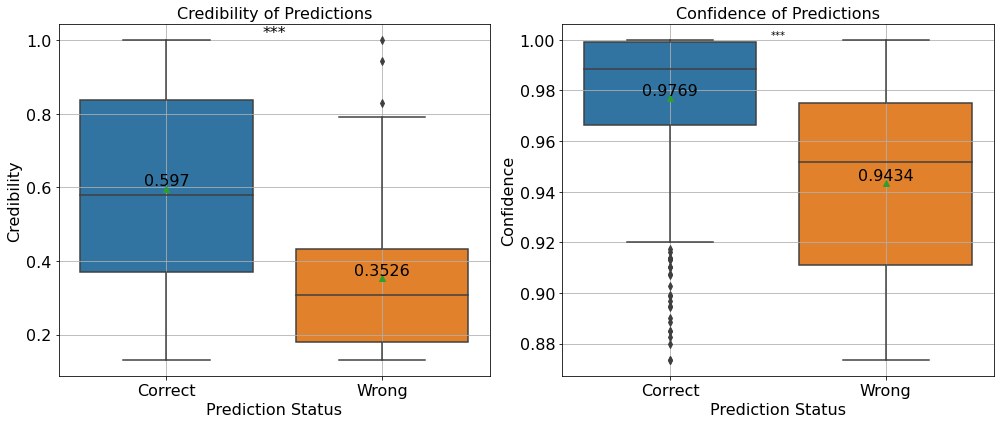

In [18]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_Radiomics_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True)
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True)
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_Radiomics_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()


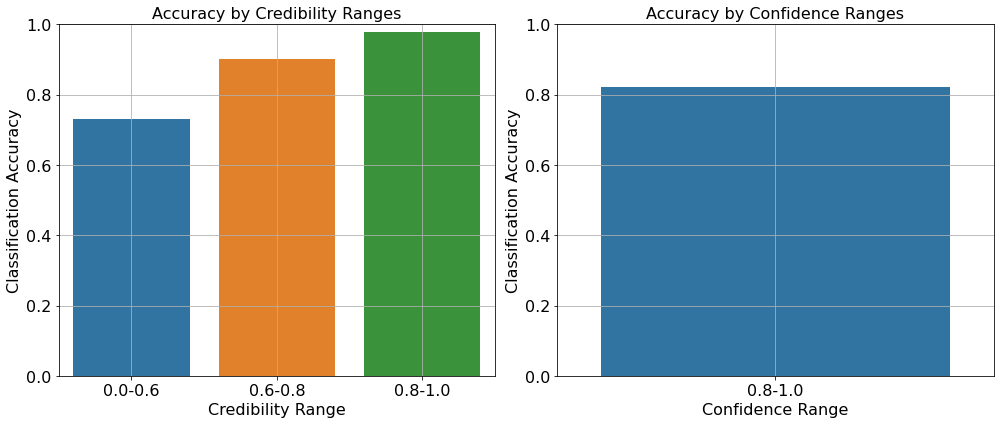

In [19]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_Radiomics_Test_Output.csv')

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_Radiomics_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()

### 5.1.2 Clinical Model

In [20]:
Lasso_Cs = [0.1,0.3,0.5,0.7,0.9]
AUPRC_results = []
for Lasso_C in Lasso_Cs:
    print(Lasso_C)
    lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=Lasso_C)
    lr.fit(X_train_std[:, clinical_idx], Y_train_smote)
    
    # Evaluate Model Performance on the training set
    train_preds, train_probs = getPredicts(lr, X_train_std[:, clinical_idx])
    train_metrics = modelEval(Y_train_smote, train_preds, train_probs)
    print('Performance on the training set: ')
    print(train_metrics)
    
    # Evaluate Model Performance on the validation set
    val_preds, val_probs = getPredicts(lr, X_val_std[:, clinical_idx])
    val_metrics = modelEval(Y_val, val_preds, val_probs)
    print('Performance on the validation set: ')
    print(val_metrics)
    
    AUPRC_results.append(val_metrics["auprc"])
best_C = Lasso_Cs[np.argsort(AUPRC_results)[::-1][0]]
print('The best AUPRC is: ', np.max(AUPRC_results))
print('The best hyperparameter is: ', best_C)

# Evaluate Model Performance on the test set
lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=best_C)
lr.fit(X_train_std[:, clinical_idx], Y_train_smote)

train_preds, train_probs = getPredicts(lr, X_train_std[:, clinical_idx])
train_metrics = modelEval(Y_train_smote, train_preds, train_probs)
test_preds, test_probs = getPredicts(lr, X_test_std[:, clinical_idx])
test_metrics = modelEval(Y_test, test_preds, test_probs)
print('Performance on the test set: ')
print(test_metrics)

0.1
Performance on the training set: 
{'auroc': 0.7685191395236293, 'accuracy': 0.6935861423220974, 'auprc': 0.7189732845974908, 'f1_score': 0.7078777058692256, 'precision': 0.6763326226012794, 'recall': 0.7425093632958801}
Performance on the validation set: 
{'auroc': 0.7713779956427015, 'accuracy': 0.6469428007889546, 'auprc': 0.23659698460576473, 'f1_score': 0.30350194552529186, 'precision': 0.18660287081339713, 'recall': 0.8125}
0.3
Performance on the training set: 
{'auroc': 0.7671069739020044, 'accuracy': 0.68937265917603, 'auprc': 0.7176191008174696, 'f1_score': 0.7027995520716686, 'precision': 0.673679690854444, 'recall': 0.7345505617977528}
Performance on the validation set: 
{'auroc': 0.7672022512708787, 'accuracy': 0.6528599605522682, 'auprc': 0.23148433508514987, 'f1_score': 0.30708661417322836, 'precision': 0.18932038834951456, 'recall': 0.8125}
0.5
Performance on the training set: 
{'auroc': 0.7649163966390327, 'accuracy': 0.6924157303370787, 'auprc': 0.713757892583274, '

#### Conformal Prediction for P-value Calculation

In [22]:
def calculate_pvalue(train_alpha, test_alpha_y):
    '''
    Compute the pvalue by making calibration with the distribution of the training non-conformity measurement
    '''
    cnt = 0
    for i in range(len(train_alpha)):
        if test_alpha_y <= train_alpha[i]: # training observation has a higher non-conformity measurement than the current (test sample, label)
            cnt += 1
    return (cnt + 1)/(len(train_alpha) + 1)

import csv
D = 2
n_labels = D

# Read in the train and test predicted probability file
train_data = np.column_stack([Y_train_smote.reshape(-1,1), 1 - train_probs.reshape(-1,1), train_probs.reshape(-1,1)]) # N X (D+1)
test_data = np.column_stack([test_preds.reshape(-1,1), 1 - test_probs.reshape(-1,1), test_probs.reshape(-1,1)]) # N X (D+1)

# Iterate over each row and calculate the non-conformity measurement (alpha), store it as a list
train_alpha = []
for i in range(len(train_data)):
    label = int(train_data[i, 0]) # extract the ground-truth label: the first column
    probs = [float(x) for x in train_data[i, 1:]] # extract the probabilities for all the possible labels
    assert len(probs) == D
    gt_prob = probs[label] # extract the ground-truth label's probability
    max_prob = max([probs[j] for j in range(n_labels) if j != label]) # extract the largest probability excluding the ground-truth label's probability
    train_alpha.append(0.5 - 0.5 * (gt_prob - max_prob)) # calculate the non-conformity measurement to be calibrated


# Iterate over each row and calculate the non-conformity measurement, pvalue and the credibility and confidence for each test case
credibility = [] # The largest P-value
confidence = [] # 1 - the second largest p-value
p_value_lst = []
for i in range(len(test_data)):
    test_label = int(test_data[i,0]) # extract the predicted label
    probs = [float(x) for x in test_data[i, 1:]] # extract the probabilities
    
    p_value = [] # record the p-value for each possible label
    for y in range(n_labels): # try each possible label
        y_prob = probs[y] # extract the current trial label's probability
        max_prob = max([probs[j] for j in range(n_labels) if j != y]) 
        y_alpha = 0.5 - 0.5 * (y_prob - max_prob) # compute the non-conformity of the trial label
        p_value.append(calculate_pvalue(train_alpha, y_alpha)) # calibrate to compute the p-value for the trial label
    assert len(p_value) == D
    p_value_lst.append(p_value.copy())
    credibility.append(p_value[test_label])
    del p_value[test_label]
    confidence.append(1 - max(p_value))

# Output the training results in a csv file
fields = ['Y_Train', 'Y_Train_Pred', 'Y_Train_Prob']
results = [[str(int(Y_train_smote[i])), str(round(train_preds[i], 4)), str(round(train_probs[i], 4))] for i in range(len(train_data))]
with open('LinearDiscriminantAnalysis_Clinical_Train_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Output the training results in a csv file
fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
results = [[str(int(test_preds[i])), str(round(test_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(p_value_lst[i][0], 4)), str(round(p_value_lst[i][1], 4))] for i in range(len(test_data))]
with open('LinearDiscriminantAnalysis_Clinical_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Save the classifier
import joblib
joblib.dump(lr, 'LinearDiscriminantAnalysis_Clinical_Model.joblib')

['LinearDiscriminantAnalysis_Clinical_Model.joblib']

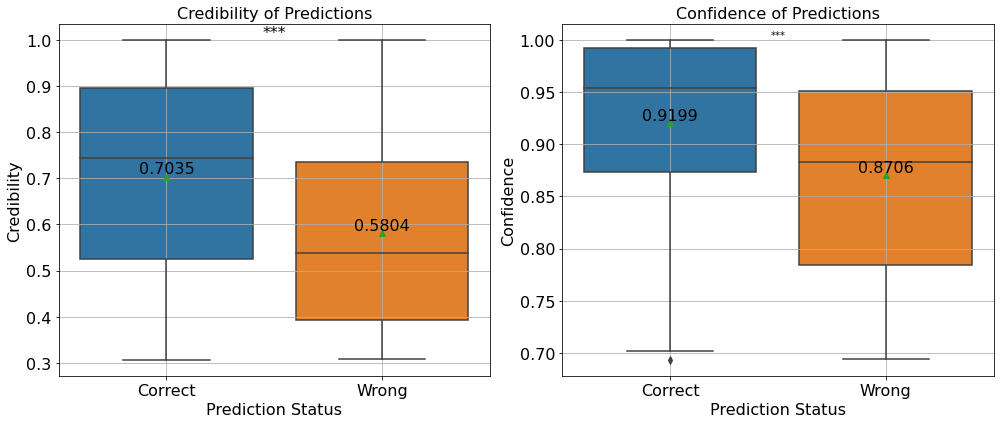

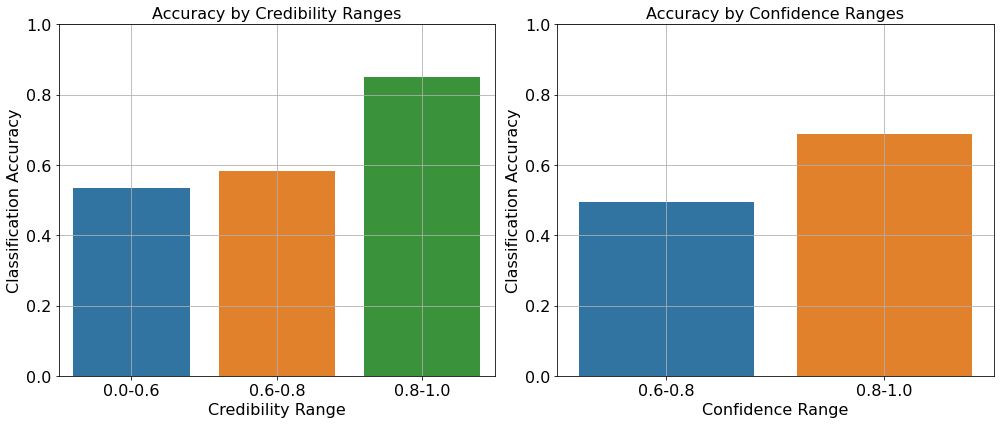

In [23]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_Clinical_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_Clinical_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_Clinical_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()

In [24]:
np.mean(correct_credibility)

0.7035387878787879

### 5.1.3 Laboratory Model

In [25]:
Lasso_Cs = [0.1,0.3,0.5,0.7,0.9]
AUPRC_results = []
for Lasso_C in Lasso_Cs:
    print(Lasso_C)
    lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=Lasso_C)
    lr.fit(X_train_std[:, lab_idx], Y_train_smote)
    
    # Evaluate Model Performance on the training set
    train_preds, train_probs = getPredicts(lr, X_train_std[:, lab_idx])
    train_metrics = modelEval(Y_train_smote, train_preds, train_probs)
    print('Performance on the training set: ')
    print(train_metrics)
    
    # Evaluate Model Performance on the validation set
    val_preds, val_probs = getPredicts(lr, X_val_std[:, lab_idx])
    val_metrics = modelEval(Y_val, val_preds, val_probs)
    print('Performance on the validation set: ')
    print(val_metrics)
    
    AUPRC_results.append(val_metrics["auprc"])
best_C = Lasso_Cs[np.argsort(AUPRC_results)[::-1][0]]
print('The best AUPRC is: ', np.max(AUPRC_results))
print('The best hyperparameter is: ', best_C)

# Evaluate Model Performance on the test set
lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=best_C)
lr.fit(X_train_std[:, lab_idx], Y_train_smote)

train_preds, train_probs = getPredicts(lr, X_train_std[:, lab_idx])
train_metrics = modelEval(Y_train_smote, train_preds, train_probs)

test_preds, test_probs = getPredicts(lr, X_test_std[:, lab_idx])
test_metrics = modelEval(Y_test, test_preds, test_probs)
print('Performance on the test set: ')
print(test_metrics)

0.1
Performance on the training set: 
{'auroc': 0.8211265281109288, 'accuracy': 0.7521067415730337, 'auprc': 0.7691530889377842, 'f1_score': 0.7519325368938861, 'precision': 0.7524613220815752, 'recall': 0.7514044943820225}
Performance on the validation set: 
{'auroc': 0.807711510530138, 'accuracy': 0.7396449704142012, 'auprc': 0.2652637193599106, 'f1_score': 0.33999999999999997, 'precision': 0.2236842105263158, 'recall': 0.7083333333333334}
0.3
Performance on the training set: 
{'auroc': 0.819151951037327, 'accuracy': 0.7492977528089888, 'auprc': 0.7691089267701666, 'f1_score': 0.747821991994349, 'precision': 0.7522501184272856, 'recall': 0.7434456928838952}
Performance on the validation set: 
{'auroc': 0.8071214596949892, 'accuracy': 0.747534516765286, 'auprc': 0.2701244649849007, 'f1_score': 0.3402061855670103, 'precision': 0.22602739726027396, 'recall': 0.6875}
0.5
Performance on the training set: 
{'auroc': 0.8161240031772082, 'accuracy': 0.7462546816479401, 'auprc': 0.76711169948

In [26]:
def calculate_pvalue(train_alpha, test_alpha_y):
    '''
    Compute the pvalue by making calibration with the distribution of the training non-conformity measurement
    '''
    cnt = 0
    for i in range(len(train_alpha)):
        if test_alpha_y <= train_alpha[i]: # training observation has a higher non-conformity measurement than the current (test sample, label)
            cnt += 1
    return (cnt + 1)/(len(train_alpha) + 1)

import csv
D = 2
n_labels = D

# Read in the train and test predicted probability file
train_data = np.column_stack([Y_train_smote.reshape(-1,1), 1 - train_probs.reshape(-1,1), train_probs.reshape(-1,1)]) # N X (D+1)
test_data = np.column_stack([test_preds.reshape(-1,1), 1 - test_probs.reshape(-1,1), test_probs.reshape(-1,1)]) # N X (D+1)

# Iterate over each row and calculate the non-conformity measurement (alpha), store it as a list
train_alpha = []
for i in range(len(train_data)):
    label = int(train_data[i, 0]) # extract the ground-truth label: the first column
    probs = [float(x) for x in train_data[i, 1:]] # extract the probabilities for all the possible labels
    assert len(probs) == D
    gt_prob = probs[label] # extract the ground-truth label's probability
    max_prob = max([probs[j] for j in range(n_labels) if j != label]) # extract the largest probability excluding the ground-truth label's probability
    train_alpha.append(0.5 - 0.5 * (gt_prob - max_prob)) # calculate the non-conformity measurement to be calibrated


# Iterate over each row and calculate the non-conformity measurement, pvalue and the credibility and confidence for each test case
credibility = [] # The largest P-value
confidence = [] # 1 - the second largest p-value
p_value_lst = []
for i in range(len(test_data)):
    test_label = int(test_data[i,0]) # extract the predicted label
    probs = [float(x) for x in test_data[i, 1:]] # extract the probabilities
    
    p_value = [] # record the p-value for each possible label
    for y in range(n_labels): # try each possible label
        y_prob = probs[y] # extract the current trial label's probability
        max_prob = max([probs[j] for j in range(n_labels) if j != y]) 
        y_alpha = 0.5 - 0.5 * (y_prob - max_prob) # compute the non-conformity of the trial label
        p_value.append(calculate_pvalue(train_alpha, y_alpha)) # calibrate to compute the p-value for the trial label
    assert len(p_value) == D
    p_value_lst.append(p_value.copy())
    credibility.append(p_value[test_label])
    del p_value[test_label]
    confidence.append(1 - max(p_value))

# Output the training results in a csv file
fields = ['Y_Train', 'Y_Train_Pred', 'Y_Train_Prob']
results = [[str(int(Y_train_smote[i])), str(round(train_preds[i], 4)), str(round(train_probs[i], 4))] for i in range(len(train_data))]
with open('LinearDiscriminantAnalysis_Laboratory_Train_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Output the training results in a csv file
fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
results = [[str(int(test_preds[i])), str(round(test_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(p_value_lst[i][0], 4)), str(round(p_value_lst[i][1], 4))] for i in range(len(test_data))]
with open('LinearDiscriminantAnalysis_Laboratory_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Save the classifier
import joblib
joblib.dump(lr, 'LinearDiscriminantAnalysis_Laboratory_Model.joblib')

['LinearDiscriminantAnalysis_Laboratory_Model.joblib']

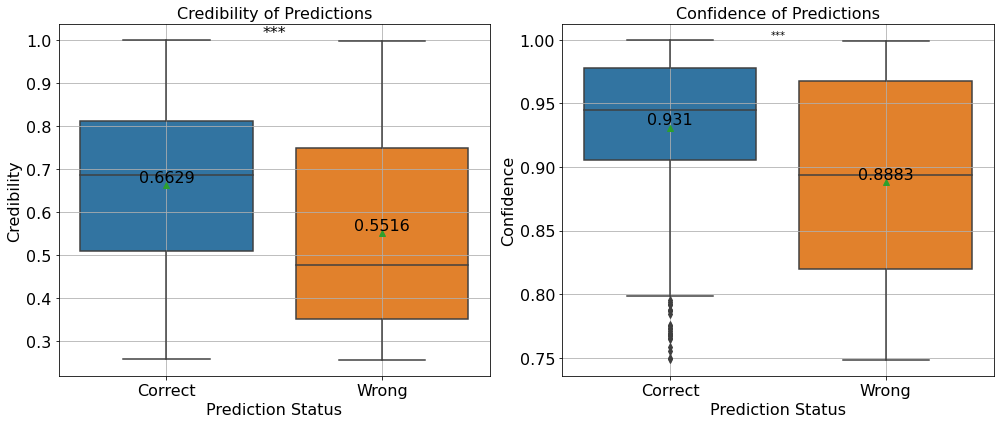

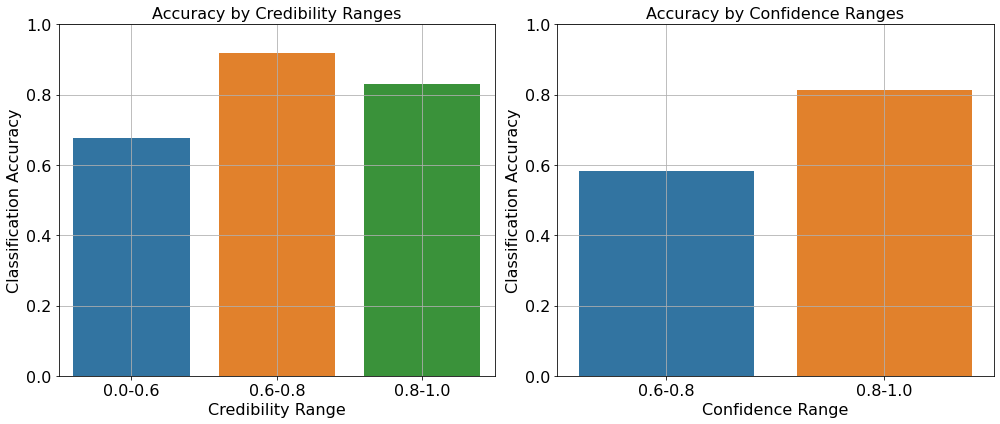

In [27]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_Laboratory_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_Laboratory_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_Laboratory_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()

### Recalculate the Precision, Recall

## 5.2 Majority Voting Multimodal Fusion

In [28]:
Radio_df = pd.read_csv('LinearDiscriminantAnalysis_Radiomics_Test_Output.csv')
Clinical_df = pd.read_csv('LinearDiscriminantAnalysis_Clinical_Test_Output.csv')
Lab_df = pd.read_csv('LinearDiscriminantAnalysis_Laboratory_Test_Output.csv')

In [29]:
majority_voting_predict_y = (np.mean(np.column_stack([Radio_df['Y_Pred'].values.reshape(-1,1), Clinical_df['Y_Pred'].values.reshape(-1,1), Lab_df['Y_Pred'].values.reshape(-1,1)]), axis = 1) >= 0.5).astype(int)

In [30]:
Y_test = Lab_df['Y_Test'].values
test_metrics = modelEval(Y_test, majority_voting_predict_y, majority_voting_predict_y)
print(test_metrics)

{'auroc': 0.7939133986928105, 'accuracy': 0.8126232741617357, 'auprc': 0.5491573548828793, 'f1_score': 0.43786982248520706, 'precision': 0.30578512396694213, 'recall': 0.7708333333333334}


## 5.3 Probability Averaging

In [31]:
Radio_train_df = pd.read_csv('LinearDiscriminantAnalysis_Radiomics_Train_Output.csv')
Clinical_train_df = pd.read_csv('LinearDiscriminantAnalysis_Clinical_Train_Output.csv')
Lab_train_df = pd.read_csv('LinearDiscriminantAnalysis_Laboratory_Train_Output.csv')

In [32]:
Radio_df = pd.read_csv('LinearDiscriminantAnalysis_Radiomics_Test_Output.csv')
Clinical_df = pd.read_csv('LinearDiscriminantAnalysis_Clinical_Test_Output.csv')
Lab_df = pd.read_csv('LinearDiscriminantAnalysis_Laboratory_Test_Output.csv')

Y_probs = np.mean(np.column_stack([Radio_df['Y_Prob'].values.reshape(-1,1), Clinical_df['Y_Prob'].values.reshape(-1,1), Lab_df['Y_Prob'].values.reshape(-1,1)]), axis = 1)
Y_preds = (Y_probs >= 0.5).astype(int)

test_metrics = modelEval(Y_test, Y_preds, Y_probs)
print(test_metrics)

{'auroc': 0.904457153231663, 'accuracy': 0.8264299802761341, 'auprc': 0.5701253360189137, 'f1_score': 0.4634146341463415, 'precision': 0.3275862068965517, 'recall': 0.7916666666666666}


In [33]:
train_probs = np.mean(np.column_stack([Radio_train_df['Y_Train_Prob'].values.reshape(-1,1),Clinical_train_df['Y_Train_Prob'].values.reshape(-1,1),Lab_train_df['Y_Train_Prob'].values.reshape(-1,1)]), axis = 1)
test_probs = np.mean(np.column_stack([Radio_df['Y_Prob'].values.reshape(-1,1), Clinical_df['Y_Prob'].values.reshape(-1,1), Lab_df['Y_Prob'].values.reshape(-1,1)]), axis = 1)
test_preds = (test_probs >= 0.5).astype(int)

In [34]:
def calculate_pvalue(train_alpha, test_alpha_y):
    '''
    Compute the pvalue by making calibration with the distribution of the training non-conformity measurement
    '''
    cnt = 0
    for i in range(len(train_alpha)):
        if test_alpha_y <= train_alpha[i]: # training observation has a higher non-conformity measurement than the current (test sample, label)
            cnt += 1
    return (cnt + 1)/(len(train_alpha) + 1)

import csv
D = 2
n_labels = D

# Read in the train and test predicted probability file
train_data = np.column_stack([Y_train_smote.reshape(-1,1), 1 - train_probs.reshape(-1,1), train_probs.reshape(-1,1)]) # N X (D+1)
test_data = np.column_stack([test_preds.reshape(-1,1), 1 - test_probs.reshape(-1,1), test_probs.reshape(-1,1)]) # N X (D+1)

# Iterate over each row and calculate the non-conformity measurement (alpha), store it as a list
train_alpha = []
for i in range(len(train_data)):
    label = int(train_data[i, 0]) # extract the ground-truth label: the first column
    probs = [float(x) for x in train_data[i, 1:]] # extract the probabilities for all the possible labels
    assert len(probs) == D
    gt_prob = probs[label] # extract the ground-truth label's probability
    max_prob = max([probs[j] for j in range(n_labels) if j != label]) # extract the largest probability excluding the ground-truth label's probability
    train_alpha.append(0.5 - 0.5 * (gt_prob - max_prob)) # calculate the non-conformity measurement to be calibrated


# Iterate over each row and calculate the non-conformity measurement, pvalue and the credibility and confidence for each test case
credibility = [] # The largest P-value
confidence = [] # 1 - the second largest p-value
p_value_lst = []
for i in range(len(test_data)):
    test_label = int(test_data[i,0]) # extract the predicted label
    probs = [float(x) for x in test_data[i, 1:]] # extract the probabilities
    
    p_value = [] # record the p-value for each possible label
    for y in range(n_labels): # try each possible label
        y_prob = probs[y] # extract the current trial label's probability
        max_prob = max([probs[j] for j in range(n_labels) if j != y]) 
        y_alpha = 0.5 - 0.5 * (y_prob - max_prob) # compute the non-conformity of the trial label
        p_value.append(calculate_pvalue(train_alpha, y_alpha)) # calibrate to compute the p-value for the trial label
    assert len(p_value) == D
    p_value_lst.append(p_value.copy())
    credibility.append(p_value[test_label])
    del p_value[test_label]
    confidence.append(1 - max(p_value))

# Output the training results in a csv file
fields = ['Y_Train', 'Y_Train_Pred', 'Y_Train_Prob']
results = [[str(int(Y_train_smote[i])), str(round(train_preds[i], 4)), str(round(train_probs[i], 4))] for i in range(len(train_data))]
with open('LinearDiscriminantAnalysis_ProbabilityAveraging_Train_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Output the training results in a csv file
fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
results = [[str(int(test_preds[i])), str(round(test_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(p_value_lst[i][0], 4)), str(round(p_value_lst[i][1], 4))] for i in range(len(test_data))]
with open('LinearDiscriminantAnalysis_ProbabilityAveraging_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Save the classifier
import joblib
joblib.dump(lr, 'LinearDiscriminantAnalysis_ProbabilityAveraging_Model.joblib')

['LinearDiscriminantAnalysis_ProbabilityAveraging_Model.joblib']

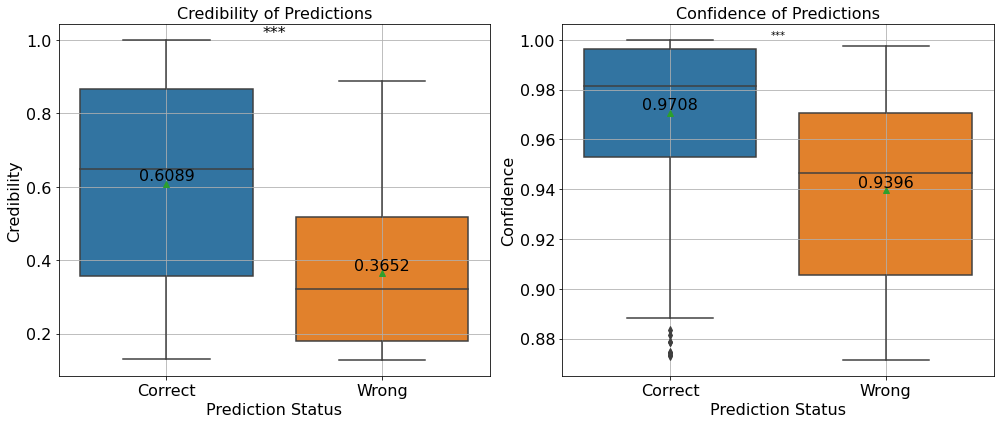

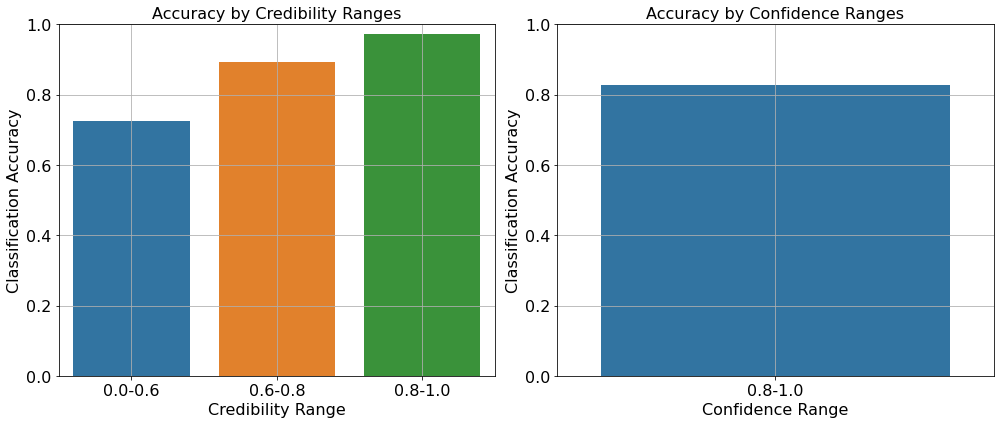

In [35]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_ProbabilityAveraging_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_ProbabiltyAveraging_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_ProbabiltyAveraging_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()

## 5.4 P-value Averaging

In [37]:
Radio_df = pd.read_csv('LinearDiscriminantAnalysis_Radiomics_Test_Output.csv')
Clinical_df = pd.read_csv('LinearDiscriminantAnalysis_Clinical_Test_Output.csv')
Lab_df = pd.read_csv('LinearDiscriminantAnalysis_Laboratory_Test_Output.csv')

Pvalue_0 = np.mean(np.column_stack([Radio_df['Pvalue_Label0'].values.reshape(-1,1), Clinical_df['Pvalue_Label0'].values.reshape(-1,1), Lab_df['Pvalue_Label0'].values.reshape(-1,1)]), axis = 1)
Pvalue_1 = np.mean(np.column_stack([Radio_df['Pvalue_Label1'].values.reshape(-1,1), Clinical_df['Pvalue_Label1'].values.reshape(-1,1), Lab_df['Pvalue_Label1'].values.reshape(-1,1)]), axis = 1)

Y_preds = np.argmax(np.column_stack([Pvalue_0, Pvalue_1]), axis = 1)
Y_probs = Pvalue_1
Y_test = Lab_df['Y_Test'].values

test_metrics = modelEval(Y_test, Y_preds, Y_probs)
print(test_metrics)

{'auroc': 0.9057053376906318, 'accuracy': 0.7988165680473372, 'auprc': 0.5501792516510263, 'f1_score': 0.4395604395604395, 'precision': 0.29850746268656714, 'recall': 0.8333333333333334}


In [38]:
# Output the training results in a csv file
fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
credibility = np.max(np.column_stack([Pvalue_0, Pvalue_1]), axis = 1)
confidence = 1 - np.min(np.column_stack([Pvalue_0, Pvalue_1]), axis = 1)

results = [[str(int(Y_preds[i])), str(round(Y_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(Pvalue_0[i], 4)), str(round(Pvalue_1[i], 4))] for i in range(len(Y_preds))]
with open('LinearDiscriminantAnalysis_PvalueFusion_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

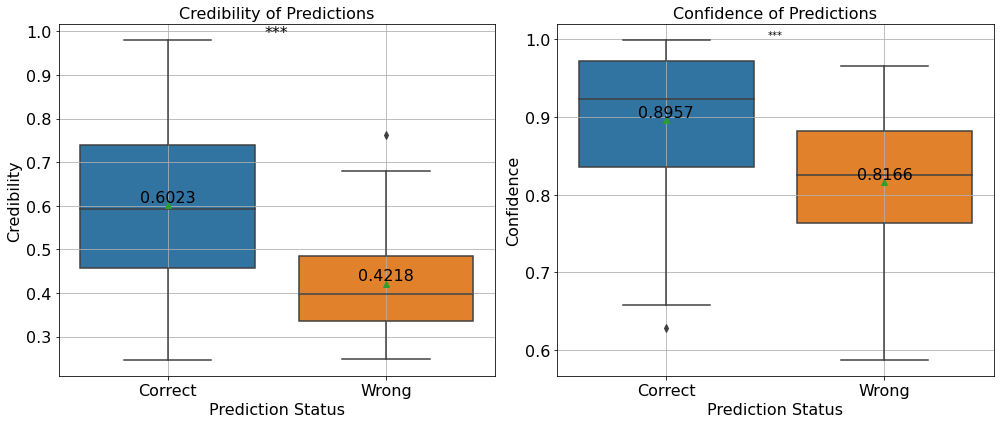

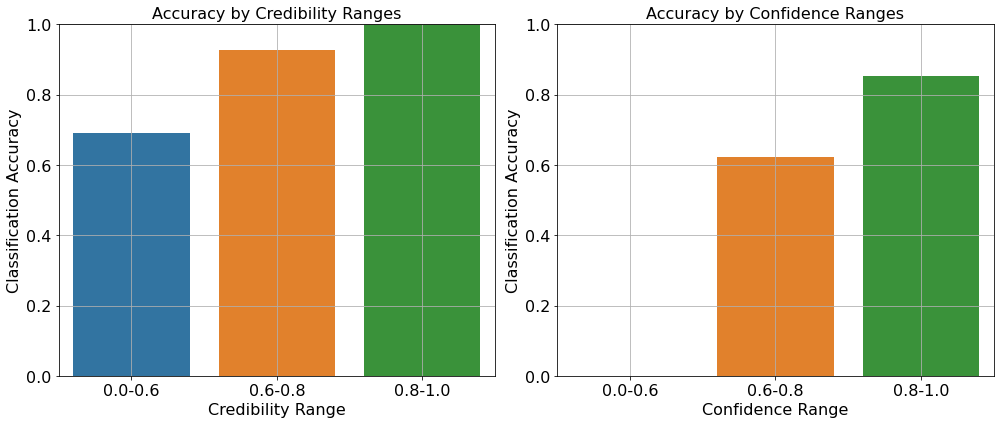

In [39]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_PvalueFusion_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_PvalueFusion_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_PvalueFusion_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()

## 5.5 Early-stage fusion

In [40]:
Lasso_Cs = [0.1,0.3,0.5,0.7,0.9]
AUPRC_results = []
for Lasso_C in Lasso_Cs:
    print(Lasso_C)
    lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=Lasso_C)
    lr.fit(X_train_std, Y_train_smote)
    
    # Evaluate Model Performance on the training set
    train_preds, train_probs = getPredicts(lr, X_train_std)
    train_metrics = modelEval(Y_train_smote, train_preds, train_probs)
    print('Performance on the training set: ')
    print(train_metrics)
    
    # Evaluate Model Performance on the validation set
    val_preds, val_probs = getPredicts(lr, X_val_std)
    val_metrics = modelEval(Y_val, val_preds, val_probs)
    print('Performance on the validation set: ')
    print(val_metrics)
    
    AUPRC_results.append(val_metrics["auprc"])
best_C = Lasso_Cs[np.argsort(AUPRC_results)[::-1][0]]
print('The best AUPRC is: ', np.max(AUPRC_results))
print('The best hyperparameter is: ', best_C)

# Evaluate Model Performance on the test set
lr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=best_C)
lr.fit(X_train_std, Y_train_smote)

train_preds, train_probs = getPredicts(lr, X_train_std)
train_metrics = modelEval(Y_train_smote, train_preds, train_probs)

test_preds, test_probs = getPredicts(lr, X_test_std)
test_metrics = modelEval(Y_test, test_preds, test_probs)
print('Performance on the test set: ')
print(test_metrics)

0.1
Performance on the training set: 
{'auroc': 0.9999995616434514, 'accuracy': 0.9948501872659176, 'auprc': 0.9999995616434032, 'f1_score': 0.9948765719608756, 'precision': 0.989805375347544, 'recall': 1.0}
Performance on the validation set: 
{'auroc': 0.7669299201161945, 'accuracy': 0.8224852071005917, 'auprc': 0.21485597661033334, 'f1_score': 0.2741935483870968, 'precision': 0.2236842105263158, 'recall': 0.3541666666666667}
0.3
Performance on the training set: 
{'auroc': 0.999389807684215, 'accuracy': 0.9775280898876404, 'auprc': 0.9993241636022626, 'f1_score': 0.978021978021978, 'precision': 0.956989247311828, 'recall': 1.0}
Performance on the validation set: 
{'auroc': 0.812636165577342, 'accuracy': 0.8422090729783037, 'auprc': 0.27363490257004586, 'f1_score': 0.3939393939393939, 'precision': 0.30952380952380953, 'recall': 0.5416666666666666}
0.5
Performance on the training set: 
{'auroc': 0.9950982970724795, 'accuracy': 0.9609082397003745, 'auprc': 0.9939152626474355, 'f1_score':

In [41]:
def calculate_pvalue(train_alpha, test_alpha_y):
    '''
    Compute the pvalue by making calibration with the distribution of the training non-conformity measurement
    '''
    cnt = 0
    for i in range(len(train_alpha)):
        if test_alpha_y <= train_alpha[i]: # training observation has a higher non-conformity measurement than the current (test sample, label)
            cnt += 1
    return (cnt + 1)/(len(train_alpha) + 1)

import csv
D = 2
n_labels = D

# Read in the train and test predicted probability file
train_data = np.column_stack([Y_train_smote.reshape(-1,1), 1 - train_probs.reshape(-1,1), train_probs.reshape(-1,1)]) # N X (D+1)
test_data = np.column_stack([test_preds.reshape(-1,1), 1 - test_probs.reshape(-1,1), test_probs.reshape(-1,1)]) # N X (D+1)

# Iterate over each row and calculate the non-conformity measurement (alpha), store it as a list
train_alpha = []
for i in range(len(train_data)):
    label = int(train_data[i, 0]) # extract the ground-truth label: the first column
    probs = [float(x) for x in train_data[i, 1:]] # extract the probabilities for all the possible labels
    assert len(probs) == D
    gt_prob = probs[label] # extract the ground-truth label's probability
    max_prob = max([probs[j] for j in range(n_labels) if j != label]) # extract the largest probability excluding the ground-truth label's probability
    train_alpha.append(0.5 - 0.5 * (gt_prob - max_prob)) # calculate the non-conformity measurement to be calibrated


# Iterate over each row and calculate the non-conformity measurement, pvalue and the credibility and confidence for each test case
credibility = [] # The largest P-value
confidence = [] # 1 - the second largest p-value
p_value_lst = []
for i in range(len(test_data)):
    test_label = int(test_data[i,0]) # extract the predicted label
    probs = [float(x) for x in test_data[i, 1:]] # extract the probabilities
    
    p_value = [] # record the p-value for each possible label
    for y in range(n_labels): # try each possible label
        y_prob = probs[y] # extract the current trial label's probability
        max_prob = max([probs[j] for j in range(n_labels) if j != y]) 
        y_alpha = 0.5 - 0.5 * (y_prob - max_prob) # compute the non-conformity of the trial label
        p_value.append(calculate_pvalue(train_alpha, y_alpha)) # calibrate to compute the p-value for the trial label
    assert len(p_value) == D
    p_value_lst.append(p_value.copy())
    credibility.append(p_value[test_label])
    del p_value[test_label]
    confidence.append(1 - max(p_value))

# Output the training results in a csv file
fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
results = [[str(int(test_preds[i])), str(round(test_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(p_value_lst[i][0], 4)), str(round(p_value_lst[i][1], 4))] for i in range(len(test_data))]
with open('LinearDiscriminantAnalysis_EarlyFusion_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Save the classifier
import joblib
joblib.dump(lr, 'LinearDiscriminantAnalysis_EarlyFusion_Model.joblib')

['LinearDiscriminantAnalysis_EarlyFusion_Model.joblib']

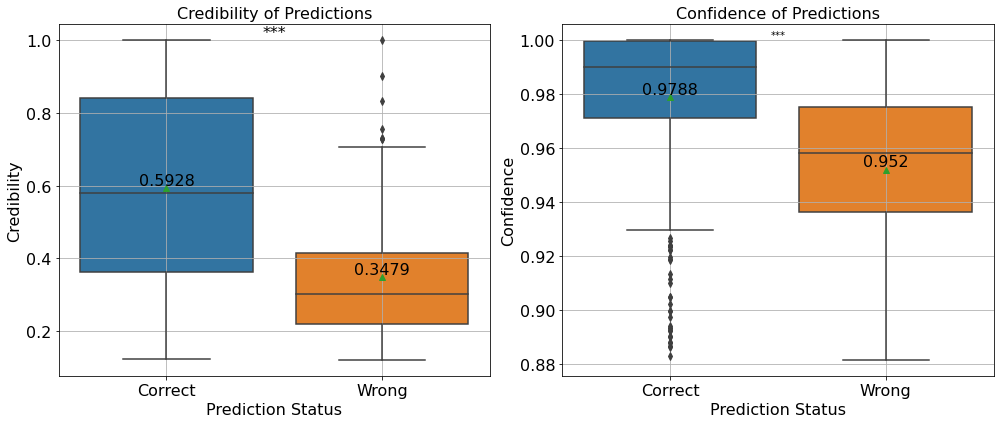

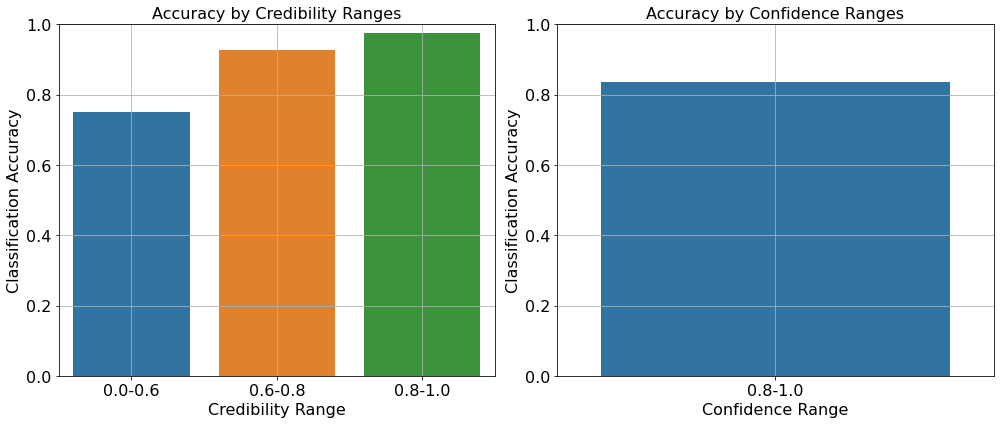

In [42]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_EarlyFusion_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_EarlyFusion_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_EarlyFusion_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()

## 5.6 Late-stage Fusion

In [13]:
X_train_sep_smote, Y_train_sep_smote = sampling.fit_resample(X_train_sep, Y_train_sep)
X_train_fusion_smote, Y_train_fusion_smote = sampling.fit_resample(X_train_fusion, Y_train_fusion)
ss = StandardScaler()
X_train_sep_std = ss.fit_transform(X_train_sep_smote)
X_train_fusion_std = ss.transform(X_train_fusion_smote)
X_val_std = ss.transform(X_val)
X_test_std = ss.transform(X_test)

lr_radiomics = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=0.9).fit(X_train_sep_std[:, radiomics_idx], Y_train_sep_smote)
lr_clinical = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=0.1).fit(X_train_sep_std[:, clinical_idx], Y_train_sep_smote)
lr_lab = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=0.5).fit(X_train_sep_std[:, lab_idx], Y_train_sep_smote)

Y_prob_radiomics = lr_radiomics.predict_proba(X_train_fusion_std[:, radiomics_idx])[:,1]
Y_prob_clinical = lr_clinical.predict_proba(X_train_fusion_std[:, clinical_idx])[:,1]
Y_prob_lab = lr_lab.predict_proba(X_train_fusion_std[:, lab_idx])[:,1]
X_train_fusion_input = np.column_stack([Y_prob_radiomics.reshape(-1,1), Y_prob_clinical.reshape(-1,1), Y_prob_lab.reshape(-1,1)])
assert X_train_fusion_input.shape[1] == 3

In [14]:
Y_val_prob_radiomics = lr_radiomics.predict_proba(X_val_std[:, radiomics_idx])[:,1]
Y_val_prob_clinical = lr_clinical.predict_proba(X_val_std[:, clinical_idx])[:,1]
Y_val_prob_lab = lr_lab.predict_proba(X_val_std[:, lab_idx])[:,1]
X_val_fusion_input = np.column_stack([Y_val_prob_radiomics.reshape(-1,1), Y_val_prob_clinical.reshape(-1,1), Y_val_prob_lab.reshape(-1,1)])

Y_test_prob_radiomics = lr_radiomics.predict_proba(X_test_std[:, radiomics_idx])[:,1]
Y_test_prob_clinical = lr_clinical.predict_proba(X_test_std[:, clinical_idx])[:,1]
Y_test_prob_lab = lr_lab.predict_proba(X_test_std[:, lab_idx])[:,1]
X_test_fusion_input = np.column_stack([Y_test_prob_radiomics.reshape(-1,1), Y_test_prob_clinical.reshape(-1,1), Y_test_prob_lab.reshape(-1,1)])

In [15]:
X_train_sep_std.shape

(3356, 9950)

In [16]:
X_train_fusion_std.shape

(916, 9950)

In [17]:
Y_val[:5]

array([0., 1., 0., 0., 0.])

In [18]:
lr_fusion.predict(X_val_fusion_input)[:5]

NameError: name 'lr_fusion' is not defined

In [113]:
X_train_fusion_input[:10]

array([[0.68927876, 0.30651897, 0.33916641],
       [0.15491779, 0.36695538, 0.54212364],
       [0.23267789, 0.52633661, 0.12548354],
       [0.25019677, 0.61893849, 0.34370773],
       [0.28415007, 0.15655282, 0.0470379 ],
       [0.25628251, 0.34214316, 0.09178492],
       [0.53379942, 0.26243338, 0.12607894],
       [0.68057756, 0.81171035, 0.76340625],
       [0.7435898 , 0.47216111, 0.21661474],
       [0.17841283, 0.43188684, 0.12916919]])

In [66]:
Y_train_fusion[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.])

In [22]:
L2_Cs = [0.05, 0.1, 0.5, 1, 10]
AUPRC_results = []
for L2_C in L2_Cs:
    print(L2_C)
    lr_fusion = LogisticRegression(penalty = 'l2', C=L2_C, solver='liblinear')
    assert X_train_fusion_input.shape[1] == 3
    lr_fusion.fit(X_train_fusion_input, Y_train_fusion_smote)
    
    # Evaluate Model Performance on the fusion training set
    train_fusion_preds, train_fusion_probs = getPredicts(lr_fusion, X_train_fusion_input)
    train_fusion_metrics = modelEval(Y_train_fusion_smote, train_fusion_preds, train_fusion_probs)
    print('Performance on the training set: ')
    print(train_fusion_metrics)
    
    # Evaluate Model Performance on the validation set
    val_preds, val_probs = getPredicts(lr_fusion, X_val_fusion_input)
    val_metrics = modelEval(Y_val, val_preds, val_probs)
    print('Performance on the validation set: ')
    print(val_metrics)
    AUPRC_results.append(val_metrics["auprc"])
    
best_fusion_C = L2_Cs[np.argsort(AUPRC_results)[::-1][0]]
print('The best AUROC is: ', np.max(AUPRC_results))
print('The best hyperparameter is: ', best_fusion_C)


# Evaluate Model Performance on the test set
lr_fusion = LogisticRegression(penalty = 'l2', C=best_fusion_C, solver='liblinear')
lr_fusion.fit(X_train_fusion_input, Y_train_fusion_smote)

train_fusion_preds, train_fusion_probs = getPredicts(lr_fusion, X_train_fusion_input)
train_fusion_metrics = modelEval(Y_train_fusion_smote, train_fusion_preds, train_fusion_probs)
print('Performance on the training set: ')
print(train_fusion_metrics)

# Evaluate Model Performance on the test set
test_preds, test_probs = getPredicts(lr_fusion, X_test_fusion_input)
test_metrics = modelEval(Y_test, test_preds, test_probs)
print('Performance on the test set: ')
print(test_metrics)

0.05
Performance on the training set: 
{'auroc': 0.81195534028718, 'accuracy': 0.7489082969432315, 'auprc': 0.7798903688583769, 'f1_score': 0.7300469483568075, 'precision': 0.7893401015228426, 'recall': 0.6790393013100436}
Performance on the validation set: 
{'auroc': 0.8531681190994918, 'accuracy': 0.8224852071005917, 'auprc': 0.4459239171919559, 'f1_score': 0.451219512195122, 'precision': 0.31896551724137934, 'recall': 0.7708333333333334}
0.1
Performance on the training set: 
{'auroc': 0.8109875860490838, 'accuracy': 0.7489082969432315, 'auprc': 0.7782476043844926, 'f1_score': 0.7300469483568075, 'precision': 0.7893401015228426, 'recall': 0.6790393013100436}
Performance on the validation set: 
{'auroc': 0.8529865649963689, 'accuracy': 0.8244575936883629, 'auprc': 0.44531408215376456, 'f1_score': 0.4539877300613497, 'precision': 0.3217391304347826, 'recall': 0.7708333333333334}
0.5
Performance on the training set: 
{'auroc': 0.8094429930779352, 'accuracy': 0.7478165938864629, 'auprc':

In [120]:
Y_train_fusion_smote.shape

(916,)

In [122]:
train_fusion_probs.shape

(916,)

In [24]:
def calculate_pvalue(train_alpha, test_alpha_y):
    '''
    Compute the pvalue by making calibration with the distribution of the training non-conformity measurement
    '''
    cnt = 0
    for i in range(len(train_alpha)):
        if test_alpha_y <= train_alpha[i]: # training observation has a higher non-conformity measurement than the current (test sample, label)
            cnt += 1
    return (cnt + 1)/(len(train_alpha) + 1)

import csv
D = 2
n_labels = D

# Read in the train and test predicted probability file
train_data = np.column_stack([Y_train_fusion_smote.reshape(-1,1), 1 - train_fusion_probs.reshape(-1,1), train_fusion_probs.reshape(-1,1)]) # N X (D+1)
test_data = np.column_stack([test_preds.reshape(-1,1), 1 - test_probs.reshape(-1,1), test_probs.reshape(-1,1)]) # N X (D+1)

assert train_data.shape[0] == X_train_fusion_smote.shape[0]

# Iterate over each row and calculate the non-conformity measurement (alpha), store it as a list
train_alpha = []
for i in range(len(train_data)):
    label = int(train_data[i, 0]) # extract the ground-truth label: the first column
    probs = [float(x) for x in train_data[i, 1:]] # extract the probabilities for all the possible labels
    assert len(probs) == D
    gt_prob = probs[label] # extract the ground-truth label's probability
    max_prob = max([probs[j] for j in range(n_labels) if j != label]) # extract the largest probability excluding the ground-truth label's probability
    train_alpha.append(0.5 - 0.5 * (gt_prob - max_prob)) # calculate the non-conformity measurement to be calibrated


# Iterate over each row and calculate the non-conformity measurement, pvalue and the credibility and confidence for each test case
credibility = [] # The largest P-value
confidence = [] # 1 - the second largest p-value
p_value_lst = []
for i in range(len(test_data)):
    test_label = int(test_data[i,0]) # extract the predicted label
    probs = [float(x) for x in test_data[i, 1:]] # extract the probabilities
    
    p_value = [] # record the p-value for each possible label
    for y in range(n_labels): # try each possible label
        y_prob = probs[y] # extract the current trial label's probability
        max_prob = max([probs[j] for j in range(n_labels) if j != y]) 
        y_alpha = 0.5 - 0.5 * (y_prob - max_prob) # compute the non-conformity of the trial label
        p_value.append(calculate_pvalue(train_alpha, y_alpha)) # calibrate to compute the p-value for the trial label
    assert len(p_value) == D
    p_value_lst.append(p_value.copy())
    credibility.append(p_value[test_label])
    del p_value[test_label]
    confidence.append(1 - max(p_value))

# Output the training results in a csv file
fields = ['Y_Train', 'Y_Train_Pred', 'Y_Train_Prob']
results = [[str(int(Y_train_fusion_smote[i])), str(round(train_fusion_preds[i], 4)), str(round(train_fusion_probs[i], 4))] for i in range(len(train_data))]
with open('LinearDiscriminantAnalysis_LateFusiony_Train_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Output the training results in a csv file
fields = ['Y_Pred', 'Y_Prob', 'Y_Test','Credibility', 'Confidence', 'Pvalue_Label0', 'Pvalue_Label1']
results = [[str(int(test_preds[i])), str(round(test_probs[i], 4)), str(int(Y_test[i])) , str(round(credibility[i],4)), str(round(confidence[i],4)), str(round(p_value_lst[i][0], 4)), str(round(p_value_lst[i][1], 4))] for i in range(len(test_data))]
with open('LinearDiscriminantAnalysis_LateFusion_Test_Output.csv', 'w', newline='') as f:
    # creating a csv writer object 
    csvwriter = csv.writer(f) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(results)

# Save the classifier
import joblib
joblib.dump(lr_fusion, 'LinearDiscriminantAnalysis_LateFusion_Model.joblib')

['LinearDiscriminantAnalysis_LateFusion_Model.joblib']

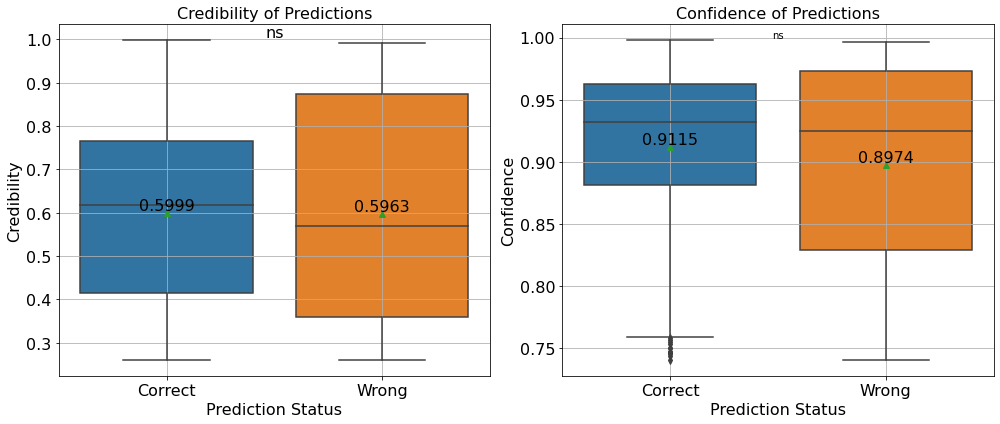

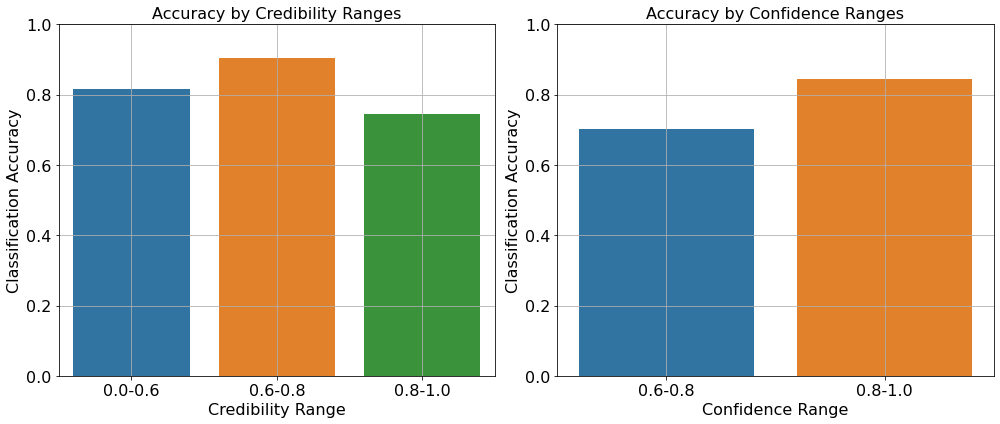

In [25]:
# Load the data
df = pd.read_csv('LinearDiscriminantAnalysis_LateFusion_Test_Output.csv')

# Prepare the data for plotting
df['Prediction_Status'] = ['Correct' if pred == true else 'Wrong' for pred, true in zip(df['Y_Pred'], df['Y_Test'])]

# Separate the data
correct_credibility = df[df['Prediction_Status'] == 'Correct']['Credibility']
wrong_credibility = df[df['Prediction_Status'] == 'Wrong']['Credibility']

correct_confidence = df[df['Prediction_Status'] == 'Correct']['Confidence']
wrong_confidence = df[df['Prediction_Status'] == 'Wrong']['Confidence']

# Perform t-tests
t_stat_cred, p_value_cred = ttest_ind(correct_credibility, wrong_credibility, equal_var=False)
t_stat_conf, p_value_conf = ttest_ind(correct_confidence, wrong_confidence, equal_var=False)

def annotate_p_value(p_value):
    """ Return appropriate annotation for p-value """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"  # Not significant

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Box plot for Credibility
plt.subplot(1, 2, 1)
sns.boxplot(x='Prediction_Status', y='Credibility', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Credibility of Predictions', fontsize = 16)
plt.ylabel('Credibility', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_credibility), str(round(np.mean(correct_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_credibility), str(round(np.mean(wrong_credibility), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Credibility']), annotate_p_value(p_value_cred), ha='center', va='bottom', color='black', fontsize = 16)
plt.grid()

# Box plot for Confidence
plt.subplot(1, 2, 2)
sns.boxplot(x='Prediction_Status', y='Confidence', data=df, showmeans=True, order = ['Correct', 'Wrong'])
plt.title('Confidence of Predictions', fontsize = 16)
plt.ylabel('Confidence', fontsize = 16)
plt.xlabel('Prediction Status', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# Annotate
plt.text(0, np.mean(correct_confidence), str(round(np.mean(correct_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(1, np.mean(wrong_confidence), str(round(np.mean(wrong_confidence), 4)), ha='center', va='bottom', color='black', fontsize = 16)
plt.text(0.5, max(df['Confidence']), annotate_p_value(p_value_conf), ha='center', va='bottom', color='black')
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_LateFusion_Test_ReliabilityAnalysis1.png', bbox_inches = 'tight', dpi = 800)
plt.show()

# Function to categorize credibility and confidence
def categorize(value):
    if value < 0.6:
        return '0.0-0.6'
    elif value < 0.8:
        return '0.6-0.8'
    else:
        return '0.8-1.0'

# Apply categorization
df['Credibility_Range'] = df['Credibility'].apply(categorize)
df['Confidence_Range'] = df['Confidence'].apply(categorize)

# Calculate accuracy within each group
def calculate_accuracy(group):
    correct_predictions = group[group['Y_Pred'] == group['Y_Test']]
    return len(correct_predictions) / len(group)

credibility_accuracy = df.groupby('Credibility_Range').apply(calculate_accuracy)
confidence_accuracy = df.groupby('Confidence_Range').apply(calculate_accuracy)


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot for Credibility
plt.subplot(1, 2, 1)
sns.barplot(x=credibility_accuracy.index, y=credibility_accuracy.values)
plt.title('Accuracy by Credibility Ranges', fontsize = 16)
plt.xlabel('Credibility Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1 for clarity
plt.grid()


# Plot for Confidence
plt.subplot(1, 2, 2)
sns.barplot(x=confidence_accuracy.index, y=confidence_accuracy.values)
plt.title('Accuracy by Confidence Ranges', fontsize = 16)
plt.xlabel('Confidence Range', fontsize = 16)
plt.ylabel('Classification Accuracy', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.savefig('LinearDiscriminantAnalysis_LateFusion_Test_ReliabilityAnalysis2.png', bbox_inches = 'tight', dpi = 800)
plt.show()